Тема: Cuped

Видео лекции:  
https://www.youtube.com/watch?v=p2WWv9Poux8
    
Видео семинара:  
https://www.youtube.com/watch?v=uyglMp0yvnE

In [42]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from itertools import product
import  seaborn as sns
from tqdm import tqdm

In [2]:
# Настройки, чтобы графики были красивыми
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Продолжительность пользовательских сессий

Сгенерим синтетические данные со средней продолжительностью пользовательских сессий

In [3]:
np.random.seed(33)

group_size = 100

df_pilot = pd.DataFrame({'y_before': np.random.normal(120, 40, group_size)})
df_control = pd.DataFrame({'y_before': np.random.normal(120, 40, group_size)})


df_pilot['y'] = df_pilot['y_before'] + np.random.normal(0, 10, group_size)
df_control['y'] = df_control['y_before'] + np.random.normal(0, 10, group_size)

effect = np.random.normal(5, 2, group_size)
df_pilot['y'] += effect

df_pilot

,y_before,y
0,107.245860,117.249746
1,55.880778,64.625057
2,58.591285,54.735771
3,97.183964,105.821062
4,111.330868,117.212246
...,...,...
95,127.809402,135.171513
96,141.433552,129.894071
97,147.371974,141.476801
98,232.851173,221.581071


In [4]:
# Разница средних до эксперимента
df_pilot['y_before'].mean(), df_control['y_before'].mean()

(118.47643316450693, 114.2499336305035)

In [5]:
# Разница средних во время эксперимента
df_pilot['y'].mean(), df_control['y'].mean()

(123.85151826262883, 116.1250165063599)

In [6]:
ttest_ind(df_pilot['y'], df_control['y'])

Ttest_indResult(statistic=1.2595710933526132, pvalue=0.20930684724231166)

Результаты не стат.значимы, поэтому применим cuped

In [7]:
def calculate_theta(y_pilot, y_control, y_pilot_cov, y_control_cov):
    y = np.hstack([y_pilot, y_control])
    y_cov = np.hstack([y_pilot_cov, y_control_cov])
    covariance = np.cov(y, y_cov)[0, 1]
    variance = y_cov.var()
    theta = covariance / variance
    return theta

In [8]:
theta = calculate_theta(df_pilot['y'].values,
                        df_control['y'].values,
                        df_pilot['y_before'].values,
                        df_control['y_before'].values)

df_pilot['y_cuped'] = df_pilot['y'] - theta * df_pilot['y_before']
df_control['y_cuped'] = df_control['y'] - theta * df_control['y_before']

ttest_ind(df_pilot['y_cuped'], df_control['y_cuped'])

Ttest_indResult(statistic=2.4869412093964995, pvalue=0.013711420318758138)

Получили стат.значимый эффект!

In [9]:
# Разница средних и дисперсий
print('Без cuped:')
print('Разница средних:', round(df_pilot['y'].mean() - df_control['y'].mean()))
print('Дисперсия в пилоте:', round(df_pilot['y'].var()))
print('Дисперсия в контроле:', round(df_control['y'].var()))

print('\nCuped:')
print('Разница средних:', round(df_pilot['y_cuped'].mean() - df_control['y_cuped'].mean()))
print('Дисперсия в пилоте:', round(df_pilot['y_cuped'].var()))
print('Дисперсия в контроле:', round(df_control['y_cuped'].var()))


Без cuped:
Разница средних: 8
Дисперсия в пилоте: 1843
Дисперсия в контроле: 1920

Cuped:
Разница средних: 3
Дисперсия в пилоте: 102
Дисперсия в контроле: 87


## Как влияет $\Theta$ на снижение дисперсии

Посмотрим на снижение дисперсии при других $\theta$

In [10]:
# Теоритически верное значение theta, рассчитанное аналитически
theta

1.0208548812876628

In [11]:
# Сгенерим тестовые theta около правильного значения
thetas = np.linspace(0.5, 1.5, 101)

vars_pilot, vars_control = [], []
for th in thetas:
    df_p = df_pilot.copy()
    df_c = df_control.copy()
    df_p['y_cuped'] = df_p['y'] - th * df_p['y_before']
    df_c['y_cuped'] = df_c['y'] - th * df_c['y_before']
    vars_pilot.append(df_p['y_cuped'].var())
    vars_control.append(df_c['y_cuped'].var())

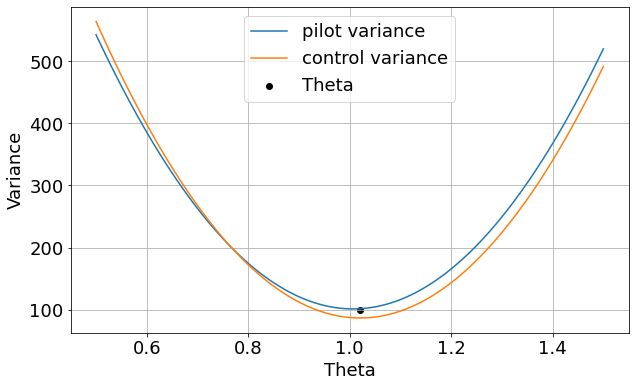

In [12]:
fig = plt.figure(figsize=(10, 6))
plt.plot(thetas, vars_pilot,label='pilot variance')
plt.plot(thetas, vars_control,label='control variance')
plt.scatter(theta, [100], c='k', label='Theta')
plt.xlabel('Theta')
plt.ylabel('Variance')
plt.grid()
plt.legend()

Видно, что аналитически рассчитанная theta близка к оптимальной

# 2. Продажи минеральной воды

Пилот направлен на увеличение продаж минеральной воды. На продажи также влияет температура воздуха. Чем выше температура, тем выше продажи.

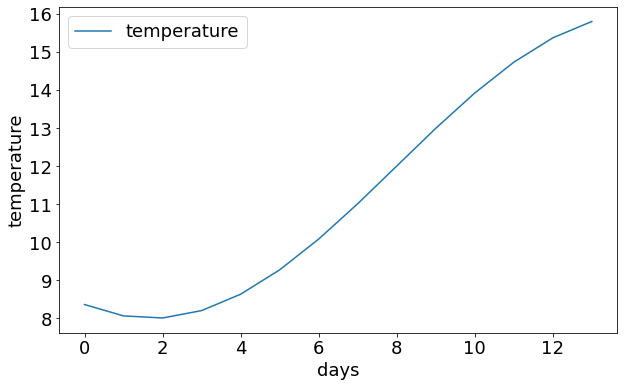

In [13]:
# Сгенерируем температуру за 14 дней

days = np.arange(14)
temperature = (np.sin((days - 8) / 4) + 3) * 4

plt.plot(days, temperature, label='temperature')
plt.xlabel('days')
plt.ylabel('temperature')
plt.legend()

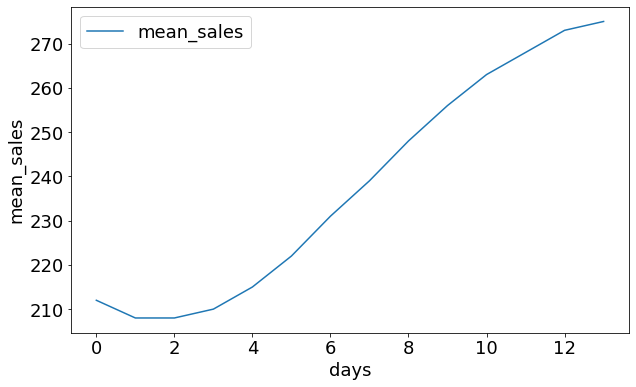

In [14]:
# Усредненные продажи по дням в зависимости от температуры
mean_sales = (np.log(temperature) * 100).astype(int)

plt.plot(days, mean_sales, label='mean_sales')
plt.xlabel('days')
plt.ylabel('mean_sales')
plt.legend()

Пилот проводился во вторые 7 дней. В эксперименте участвует 10 магазинов: 5 в пилотной группе, 5 в контрольной

In [15]:
df_1 = pd.DataFrame({'day': days, 'mean_sales': mean_sales, 'temperature': np.round(temperature, 1)})
df_1

,day,mean_sales,temperature
0,0,212,8.4
1,1,208,8.1
2,2,208,8.0
3,3,210,8.2
4,4,215,8.6
5,5,222,9.3
6,6,231,10.1
7,7,239,11.0
8,8,248,12.0
9,9,256,13.0


In [16]:
shops = np.arange(10)
df_2 = pd.DataFrame(product(days, shops), columns=['day', 'shop'])
df_2['pilot'] = (df_2['shop'] < 5).astype(int)
df_2

,day,shop,pilot
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
135,13,5,0
136,13,6,0
137,13,7,0
138,13,8,0


In [17]:
np.random.seed(44)
df = df_2.merge(df_1, how='inner', on='day')
df['y'] = df['mean_sales'] + np.random.normal(0, 10, df.shape[0]).astype(int)
# Добавляю эффект для пилота
mask = (df['day'] >= 7) & (df['pilot'] == 1)
df.loc[mask, 'y'] += np.random.normal(9, 10, mask.sum()).astype(int)
df

,day,shop,pilot,mean_sales,temperature,y
0,0,0,1,212,8.4,205
1,0,1,1,212,8.4,225
2,0,2,1,212,8.4,224
3,0,3,1,212,8.4,196
4,0,4,1,212,8.4,198
...,...,...,...,...,...,...
135,13,5,0,275,15.8,293
136,13,6,0,275,15.8,289
137,13,7,0,275,15.8,270
138,13,8,0,275,15.8,266


Text(0, 0.5, 'y')

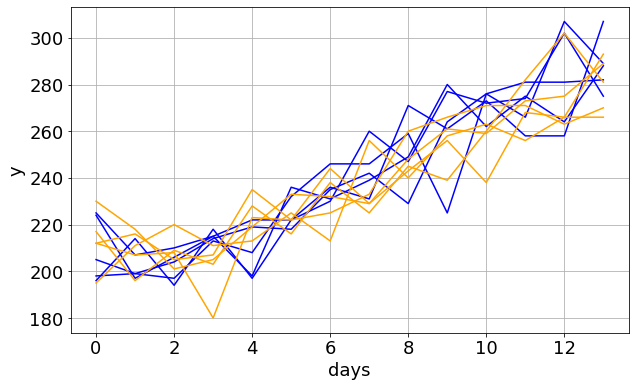

In [18]:
for name, df_ in df.groupby('shop'):
    color = 'blue' if name < 5 else 'orange'
    plt.plot(df_['day'], df_['y'], c=color)
plt.grid()
plt.xlabel('days')
plt.ylabel('y')

<AxesSubplot:xlabel='day'>

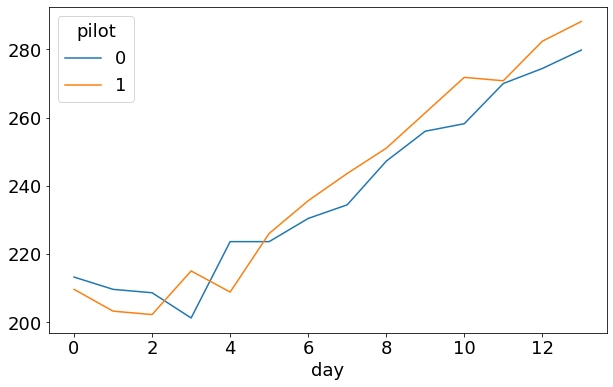

In [19]:
# Усредним магазины пилотной и контрольной групп
df.groupby(['pilot', 'day'])[['y']].mean() \
    .reset_index() \
    .pivot(columns='pilot', index='day', values='y') \
    .plot()

In [20]:
df_pilot_exp = df[(df['day']>= 7) & (df['pilot'] == 1)]
df_pilot_before = df[(df['day'] < 7) & (df['pilot'] == 1)]
df_control_exp = df[(df['day'] >= 7) & (df['pilot'] == 0)]
df_control_before = df[(df['day'] < 7) & (df['pilot'] == 0)]

_, pval = ttest_ind(df_pilot_exp['y'], df_control_exp['y'])

print('Delta:', df_pilot_exp['y'].mean() - df_control_exp['y'].mean())
print('P-value:', pval)

Delta: 7.028571428571411
P-value: 0.1341546423954113


Результаты не стат.значимы

## Применим cuped

In [21]:
theta = calculate_theta(df_pilot_exp['y'].values,
                        df_control_exp['y'].values,
                        df_pilot_before['y'].values,
                        df_control_before['y'].values)

df_pilot_exp.loc[:, 'y_cuped'] = df_pilot_exp['y'].values - theta * df_pilot_before['y'].values
df_control_exp.loc[:, 'y_cuped'] = df_control_exp['y'].values - theta * df_control_before['y'].values

_, pval = ttest_ind(df_pilot_exp['y_cuped'], df_control_exp['y_cuped'])

print('Delta:', df_pilot_exp['y_cuped'].mean() - df_control_exp['y_cuped'].mean())
print('P-value:', pval)
print('Var before:', df_pilot_exp['y'].var())
print('Var cuped:', df_pilot_exp['y_cuped'].var())


Delta: 7.673960859763355
P-value: 0.0840509620294774
Var before: 414.2638655462186
Var cuped: 352.91733144029706


/home/lucky/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Дисперсия немного снизилась, но стат.значимости нет

## Попробуем cuped для температуры

т.к. мы не влияем не температуру своим экспермиентом, то можем брать ее значения во время эксперимента

In [22]:
theta = calculate_theta(df_pilot_exp['y'].values,
                        df_control_exp['y'].values,
                        df_pilot_exp['temperature'].values,
                        df_control_exp['temperature'].values)

df_pilot_exp.loc[:, 'y_cuped'] = df_pilot_exp['y'].values - theta * df_pilot_exp['temperature'].values
df_control_exp.loc[:, 'y_cuped'] = df_control_exp['y'].values - theta * df_control_exp['temperature'].values

_, pval = ttest_ind(df_pilot_exp['y_cuped'], df_control_exp['y_cuped'])

print('Delta:', df_pilot_exp['y_cuped'].mean() - df_control_exp['y_cuped'].mean())
print('P-value:', pval)
print('Var before:', df_pilot_exp['y'].var())
print('Var cuped:', df_pilot_exp['y_cuped'].var())

Delta: 7.028571428571411
P-value: 0.020566968806308664
Var before: 414.2638655462186
Var cuped: 191.34359263440115


/home/lucky/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Дисперсия снизилась более чем в 2 раза.  
Получили стат.значимые различия.  
Ура!

# 3. Cuped + ML

Возьмем набор данных о домах в Бостоне

In [23]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()

print(boston_dataset.keys())

print(boston_dataset['DESCR'])

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX

In [24]:
X = pd.DataFrame(boston_dataset['data'], columns=boston_dataset['feature_names'])
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [25]:
Y = pd.DataFrame(boston_dataset['target'], columns=['y'])
Y

,y
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2
...,...
501,22.4
502,20.6
503,23.9
504,22.0


<AxesSubplot:ylabel='Frequency'>

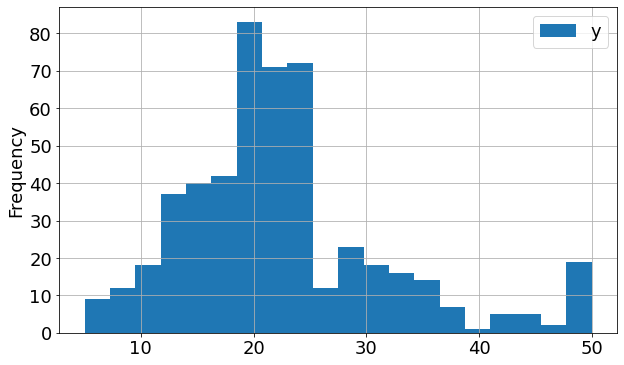

In [26]:
Y.plot(kind='hist', bins=20, grid=True)

Предположим, что мы взяли 2 группы по 100 домов и предприняли в пилотной группе какие-то усилия, чтобы повысить стоимость домов

In [27]:
np.random.seed(24)

group_size = 100

idx = np.random.choice(Y.index, 2 * group_size, replace=False)
a_idx = idx[:group_size]
b_idx = idx[group_size:]

_, pval = ttest_ind(Y.loc[a_idx, 'y'], Y.loc[b_idx, 'y'])
print('Diff:', f"{Y.loc[b_idx, 'y'].mean() - Y.loc[a_idx, 'y'].mean():.2f}")
print(f"P-value: {pval:.2f}")

Diff: 0.18
P-value: 0.89


Стат. значимой разницы нет. Так и должно быть, т.к. мы еще не предприняли никаких действий над группой B

## Добавим эффект в пилотную группу

In [28]:
Y.loc[b_idx, 'y'] += np.random.normal(1.5, 2, group_size)

_, pval = ttest_ind(Y.loc[a_idx, 'y'], Y.loc[b_idx, 'y'])
print('Diff:', f"{Y.loc[b_idx, 'y'].mean() - Y.loc[a_idx, 'y'].mean():.2f}")
print(f"P-value: {pval:.2f}")

Diff: 1.97
P-value: 0.13


Стат.значимой разницы все еще нет

Допустим, мы знаем стоимость других домов. Можем обучить модель прогноза стоимости и использовать этот прогноз для CUPED

## 3.2. Изучение признаков и обучение модели

In [29]:
# Дома из исходного датасета, которые не попали в экспериментальные группы А и В
other_idx = np.setdiff1d(Y.index.values, np.hstack([a_idx, b_idx]))
other_idx.shape

(306,)

<AxesSubplot:>

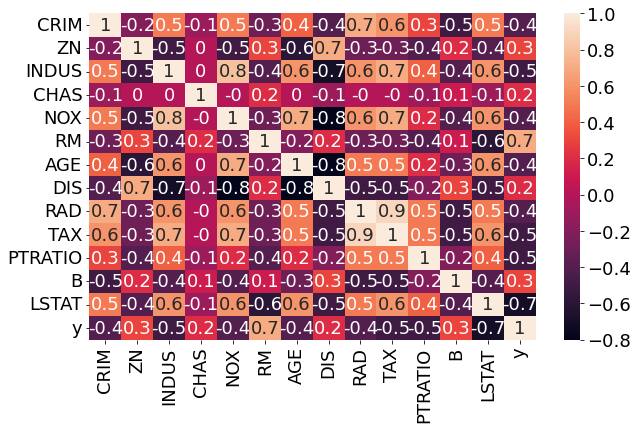

In [30]:
# Посмотрим корреляции признаков с таргетом для домом из группы other
other = X.loc[other_idx]
other['y'] = Y.loc[other_idx, 'y']

correlation_matrix = other.corr().round(1)
sns.heatmap(data=correlation_matrix, annot=True)

Наибольшая корреляция (по модулю) целевой переменной с признаками LSTAT и RM

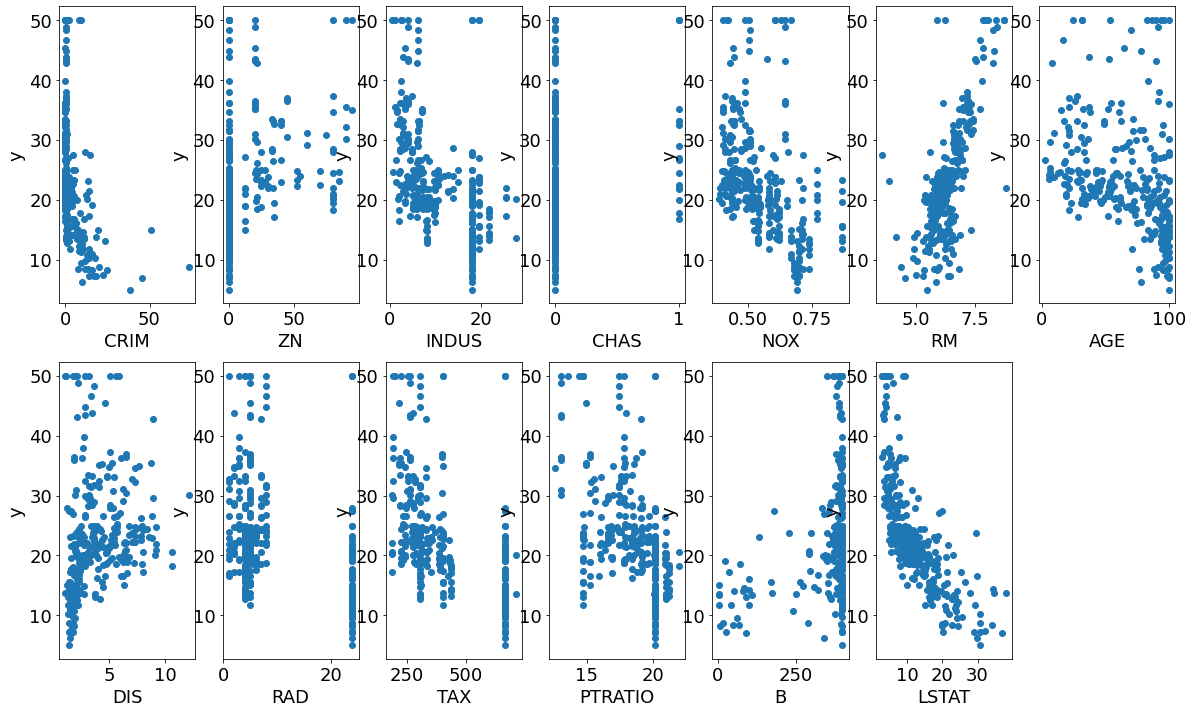

In [31]:
features = X.columns

plt.figure(figsize=(20, 12))
rows_cnt = len(features) // 5
cols_cnt = len(features) // rows_cnt + 1
for i, feat in enumerate(features):
    plt.subplot(rows_cnt,  cols_cnt, i + 1)
    plt.scatter(other[feat], other['y'])
    plt.xlabel(feat)
    plt.ylabel('y')

Обучим линейную модель и сравним ее качество с наивным прогнозом = средняя стоимость домов

In [32]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

# Сила регуляризации
alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10]

model = RidgeCV(alphas=alphas)
model.fit(other.drop(columns='y'), other['y'])
# Предсказания для пилотной группы
preds = model.predict(X.loc[b_idx])
# Наивный прогноз = просто среднее значение
naive_preds = [other['y'].mean()] * preds.shape[0]

print(f"Ошибка предсказания: {mean_squared_error(preds, Y.loc[b_idx, 'y']):.2f}")
print(f"Ошибка наивного прогноза: {mean_squared_error(preds, naive_preds):.2f}")


Ошибка предсказания: 29.20
Ошибка наивного прогноза: 58.04


Предсказания модели лучше, чем наивный прогноз

In [33]:
# Посмотрим на корреляцию предикта и таргета
print(f"{np.corrcoef(preds, Y.loc[b_idx, 'y'])[0, 1]:.2f}")

0.86


Корреляция высокая. Применим CUPED

# 3.3 CUPED на предсказаниях модели

In [36]:
a_preds = model.predict(X.loc[a_idx])
b_preds = model.predict(X.loc[b_idx])

theta = calculate_theta(Y.loc[a_idx, 'y'],
                        Y.loc[b_idx, 'y'],
                       a_preds,
                       b_preds)

y_control_cuped = Y.loc[a_idx, 'y'] - theta * a_preds
y_pilot_cuped = Y.loc[b_idx, 'y'] - theta * b_preds

_, pval = ttest_ind(y_control_cuped, y_pilot_cuped)
print('Diff:', f"{y_pilot_cuped.mean() - y_control_cuped.mean():.2f}")
print(f"P-value: {pval:.2f}")

Diff: 1.65
P-value: 0.02


Получили стат.значимый результат!

In [45]:
# Проверим разномерность p_value
yy = np.hstack([y_control_cuped, y_pilot_cuped])

rr = []

for _ in tqdm(range(1000)):
    np.random.shuffle(yy)
    y1 = yy[:100]
    y2 = yy[100:]
    
    _, res = ttest_ind(y1, y2)
    rr.append(res)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3933.36it/s]


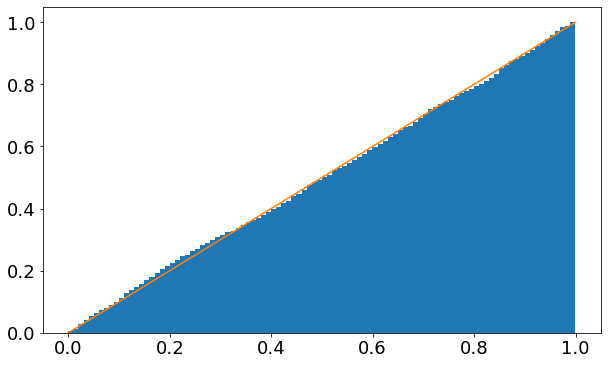

In [55]:
plt.hist(rr, bins=100, cumulative=True, density=True);
plt.plot([0, 1], [0, 1])

P-value распределен равномерно. Так и должно быть